# Project 1 – Classification, weight sharing, auxiliary losses

The objective of this project is to test **different architectures** to compare two digits visible in a
two-channel image. It aims at showing in particular the impact of **weight sharing**, and of the use of an
auxiliary loss to help the training of the main objective.
It should be implemented with PyTorch only code, in particular without using other external libraries
such as scikit-learn or numpy.
## Data
The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate˙pair˙sets(N) defined in the file
dlc˙practical˙prologue.py. 

This function returns six tensors:

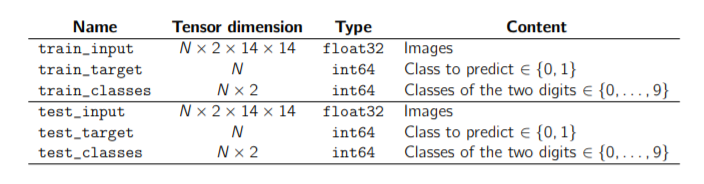

## Objective
The goal of the project is to compare different architectures, and assess the performance improvement that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000 parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error rate. Performance estimates provided in your report should be estimated through 10+ rounds for each architecture, where both data and weight initialization are randomized, and you should provide estimates of standard deviations

Need to add normalization of the train data. 

### Load the data

In [20]:
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
N = 1000

In [36]:
train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes = prologue.generate_pair_sets(N)

# Normalize the training sets
mu, std = train_inputs.mean(), train_inputs.std() 
train_inputs.sub_(mu).div_(std)

# Normalize the test sets
test_inputs.sub_(mu).div_(std)

train_targets, test_targets = train_targets.float(), test_targets.float()

### Get a sense of it

Let us print the sizes of the tensors:

In [22]:
for name, tensor in zip(['train_input', 'train_target', 'train_classes', 'test_input', 'test_target', 'test_classes'], 
                        [train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes]):
    print(name, tensor.size())

train_input torch.Size([1000, 2, 14, 14])
train_target torch.Size([1000])
train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14])
test_target torch.Size([1000])
test_classes torch.Size([1000, 2])


Everything looks fine!

Now let us make sure that the `train_target` really corresponds to the `train_classes`.

In [23]:
# For example, for the first one
print('train_classes are', train_classes[0])
print('train_target is', train_targets[0])

# For example, for the fourth one
print('train_classes are', train_classes[4])
print('train_target is', train_targets[4])

# For example, for the sixth one
print('train_classes are', train_classes[6])
print('train_target is', train_targets[6])

train_classes are tensor([5, 8])
train_target is tensor(1)
train_classes are tensor([7, 0])
train_target is tensor(0)
train_classes are tensor([3, 0])
train_target is tensor(0)


Funny, but everything looks fine!

## Architectures

### Convnet with two signals corresponding to each image.

#### Creating the Net module

In [24]:
class Net(nn.Module):
    def __init__(self, nb_hidden = 128):        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.fc3 = nn.Linear(10, 1)
        
        ## we can play by 
        ## 1. add more and different layers
        ## 2. change number of hidden unit. Actually I think here is too much for the input dimension
        ## 3. kernel size but this should fit

    def forward(self, x):
        
        # input has [mini_batch_size, 2, 14, 14], output has [mini_batch_size, 32, 5, 5]
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        
        # input has [mini_batch_size, 32, 5, 5], output has [mini_batch_size, 64, 2, 2]
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        
        # input has [mini_batch_size, 64, 2, 2], output has [mini_batch_size, 256]
        x = x.view(x.size(0), -1) ## (at least in my mind) this view should keep track of the two images

        # input has [mini_batch_size, 256], output has [mini_batch_size, nb_hidden]
        x = F.relu(self.fc1(x))
        
        # input has [mini_barch_size, 128], output has [mini_batch_size, 10]
        x = F.relu(self.fc2(x))
        
        # input has [mini_barch_size, 10], output is 1D mini_batch_size vector
        x = self.fc3(x).view(-1)
        
        return x

In [39]:
def train_model(model, train_inputs, train_targets, mini_batch_size=100, remember_losses=True):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train_inputs : torch.Tensor object
            The input train feature set
        train_targets : torch.Tensor object
            The input train label set
        mini_batch_size : int
            The size of the batch processing size
        remember_losses : boolean
            True if remember losses for model evaluation, False if not
            
        Returns
        -------
        
        NN object or (NN object, list)
            If remember_losses is True then the function returns both
            the trained model and the list of losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
    """
    
    # Defining the learning rate and number of epochs
    lr, nb_epochs, losses = 1e-3, 20, []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target in zip(train_inputs.split(mini_batch_size), train_targets.split(mini_batch_size)):
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        losses.append(loss)
        print('%dth epoch is finished and the loss is %f' % (e + 1, loss))
           
    return model, losses

def compute_nb_errors(model, data_inputs, targets, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target in zip(data_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output = model(data_input)
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

In [40]:
two_channel_net = Net()
two_channel_net, losses = train_model(two_channel_net, train_inputs, train_targets)

1th epoch is finished and the loss is 0.694231
2th epoch is finished and the loss is 0.663830
3th epoch is finished and the loss is 0.593505
4th epoch is finished and the loss is 0.499975
5th epoch is finished and the loss is 0.444748
6th epoch is finished and the loss is 0.399160
7th epoch is finished and the loss is 0.388020
8th epoch is finished and the loss is 0.331640
9th epoch is finished and the loss is 0.274886
10th epoch is finished and the loss is 0.246843
11th epoch is finished and the loss is 0.214869
12th epoch is finished and the loss is 0.176585
13th epoch is finished and the loss is 0.153294
14th epoch is finished and the loss is 0.125586
15th epoch is finished and the loss is 0.101859
16th epoch is finished and the loss is 0.081229
17th epoch is finished and the loss is 0.061388
18th epoch is finished and the loss is 0.044765
19th epoch is finished and the loss is 0.031464
20th epoch is finished and the loss is 0.026567


In [41]:
nb_errors_train = compute_nb_errors(two_channel_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors(two_channel_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 1000 out of 1000
Number of correct test classifications: 829 out of 1000


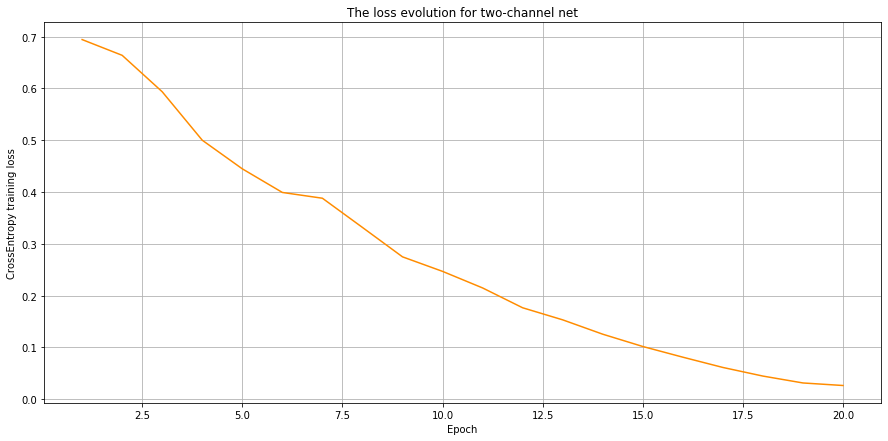

In [45]:
import matplotlib.pyplot as plt
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, losses, 'darkorange')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net');

In [24]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            
            # input has [mini_batch_size, 1, 14, 14], output has [mini_batch_size, 4, 12, 12]
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4), #same size
            nn.Dropout2d(p=.2),
            
            # input has [mini_batch_size, 4, 12, 12], output has [mini_batch_size, 8, 10, 10 ]
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

             # input has [mini_batch_size, 8, 10, 10 ], output has [mini_batch_size, 8, 8, 8 ]
            nn.Conv2d(8, 8, kernel_size=3), #what's the use of this?
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        
        self.fc1 = nn.Sequential(
            # input has [mini_batch_size, 512 ], output has [mini_batch_size, 1]
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 10)#is this the digit?
            #or should we do lather something like this?
            # _, predicted_classes = output.max(1) #get the predicted value
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        # input has [mini_batch_size, 8, 8, 8 ], output has [mini_batch_size, 512 ]
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [63]:
def train_model(model, train_input, train_target, train_classes, mini_batch_size):

    criterion = nn.MSELoss()
    
    
    lr, nb_epochs = 1e-1, 50 #we could use an optimizer instead

    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    for e in range(0, 25):
        sum_loss = 0
        # We do this with mini-batches
        for inputs, targets, classes in zip(train_input.split(mini_batch_size),
                                           train_target.split(mini_batch_size),
                                           train_classes.split(mini_batch_size)):
            input_1, input_2 = inputs[:, 0, :, :].view(-1, 1, 14, 14), inputs[:, 1, :, :].view(-1, 1, 14, 14)
            class_1, class_2 = classes[:, 0], classes[:, 1]
            output1, output2 = model(input_1, input_2)
            loss_1 = criterion(output1, class_1)
            loss_2 = criterion(output2, class_2)
            loss = loss_1 + loss_2
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            optimizer.step()

        print('attemp number',e,'gives error', sum_loss)
    return e, sum_loss

In [64]:
model = SiameseNetwork()
train_model(model, train_input.float(), train_target.float(), train_classes.float(), 100)

attemp number 0 gives error 3212.7715072631836
attemp number 1 gives error 378.1322441101074
attemp number 2 gives error 212.67155075073242
attemp number 3 gives error 166.8788604736328
attemp number 4 gives error 171.54719924926758
attemp number 5 gives error 166.00430870056152
attemp number 6 gives error 163.11826992034912
attemp number 7 gives error 163.7894639968872
attemp number 8 gives error 163.59114742279053
attemp number 9 gives error 163.42170333862305
attemp number 10 gives error 163.3319272994995
attemp number 11 gives error 163.31031703948975
attemp number 12 gives error 163.34890460968018
attemp number 13 gives error 163.35874557495117
attemp number 14 gives error 163.34845352172852
attemp number 15 gives error 163.34256553649902
attemp number 16 gives error 163.34632301330566
attemp number 17 gives error 163.3500270843506
attemp number 18 gives error 163.35008430480957
attemp number 19 gives error 163.3496675491333
attemp number 20 gives error 163.35063934326172
attemp n

(24, 163.35380268096924)

Ways to train the model:
- We output the digit values of two images, then we use MSELoss to fit the target classes for each image + the target value. In the end we have the summarized 3 losses: MSE_Loss_full = a*MSE_Loss_image_1* + b*MSE_Loss_image_2* + c*MSE_Loss_target_value*
- We can merge somehow the two output of the digits **inside** the model and then output the scalar value with is our evaluation of the target value (same network output as in the first attempt)